Up-to-date version: https://colab.research.google.com/drive/12Byx1oMV1mNsHHJZYC66l5QctGS9uFgs

## Stimulus response habituation

The task and the simulated plot shown here is redrawn from the work of N. Timme and C. Lapish "A Tutorial for Information Theory in Neuroscience", 2018.

A sensory neuron $S$ responds to stimulation of the gill and siphon. This sensory neuron then makes a synapse on a motor neuron $M$ that controls the withdrawal muscle. It has been shown that the habituation process is due to changes in the synapse between the sensory neuron and the motor neuron. Excitatory connection from the stimulated neuron $S$ to the postsynaptic neuron $M$ decreased in strength with repeated stimulation via an exponential decay. Here is the simulation.

In [0]:
!pip install numpy==1.15.4 matplotlib==3.0.1

    100% |████████████████████████████████| 13.9MB 2.3MB/s 
    100% |████████████████████████████████| 12.9MB 2.6MB/s 
    100% |████████████████████████████████| 952kB 17.4MB/s 
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Found existing installation: matplotlib 2.1.2
    Uninstalling matplotlib-2.1.2:
      Successfully uninstalled matplotlib-2.1.2


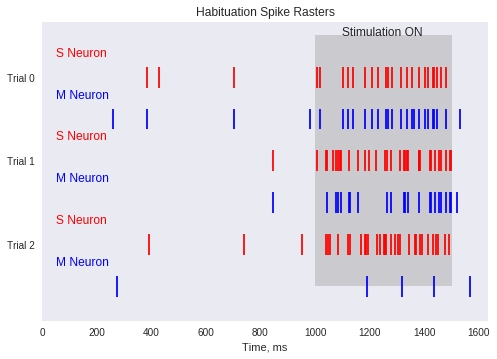

In [0]:
import matplotlib.pyplot as plt
import numpy as np

FIRING_RATE_NOISE = 0.005
FIRING_RATE_STIMULI = 0.1

STIMULI_START = 1000
STIMULI_DURATION = 500

SENSORY_MOTOR_STRENGTHS = (0.9, 0.5, 0.05)  # 3 trials; between 0 and 1

np.random.seed(26)


def generate_spikes(rate: float, duration: int):
    """
    :param rate: neuron's firing rate
    :param duration: experiment duration, ms
    :return: neuron spike raster with Gamma distributed inter-spike intervals
    """
    spikes = np.zeros(duration, dtype=int)
    if rate == 0:
        return spikes
    expected_size = int(rate * duration)
    t_spikes = []
    start = 0
    while True:
        intervals = np.random.gamma(shape=2, scale=1 / rate, size=expected_size)
        t_spikes = np.r_[t_spikes, np.cumsum(intervals) + start]
        start = t_spikes[-1]
        if start >= duration:
            break
    t_spikes = t_spikes.astype(int)
    t_spikes = t_spikes[t_spikes <= duration - 1]
    spikes[t_spikes] = 1
    return spikes


def generate_sensory_spikes(rate: float, duration: int):
    """
    :param rate: neuron firing rate
    :param duration: stimulus duration
    :return: sensory spikes raster
    """
    noise = generate_spikes(rate=FIRING_RATE_NOISE, duration=duration)
    sensory_spikes = generate_spikes(rate=rate, duration=duration)
    sensory_spikes ^= noise
    return sensory_spikes


def generate_motor_spikes(sensory_spikes, connection_strength: float):
    """
    :param sensory_spikes: sensory spikes raster
    :param connection_strength: weight between sensory and motor neurons
    :return: motor spikes raster
    """
    assert 0 <= connection_strength <= 1
    p_spikes = np.random.uniform(low=0, high=1, size=len(sensory_spikes))
    noise = generate_spikes(rate=FIRING_RATE_NOISE, duration=len(sensory_spikes))
    motor_spikes = sensory_spikes * (p_spikes < connection_strength)
    motor_spikes ^= noise
    return motor_spikes


def generate_experiments(connection_strengths=SENSORY_MOTOR_STRENGTHS, motor_random=False):
    """
    :param connection_strengths: list of weights between sensory and motor neurons
    :param motor_random: are motor spikes independent from the given sensory neuron S?
                         For example, motor neuron M might be connected to other (unobserved) sensory neuron.
                         If True, simulates random motor spikes.
    :return: sensory and motor neurons raster trials
    """
    def generate_stimulated_spikes(stimulus_rate):
        return np.r_[generate_spikes(rate=FIRING_RATE_NOISE, duration=STIMULI_START),
                     generate_sensory_spikes(rate=stimulus_rate, duration=STIMULI_DURATION),
                     generate_spikes(rate=FIRING_RATE_NOISE, duration=300)]

    sensory_spikes_experiments = []
    motor_spikes_experiments = []
    for connection_strength in connection_strengths:
        sensory_spikes = generate_stimulated_spikes(stimulus_rate=FIRING_RATE_STIMULI)
        sensory_spikes_experiments.append(sensory_spikes)
        if motor_random:
            motor_spikes = generate_stimulated_spikes(stimulus_rate=connection_strength * FIRING_RATE_STIMULI)
        else:
            motor_spikes = generate_motor_spikes(sensory_spikes=sensory_spikes, connection_strength=connection_strength)
        motor_spikes_experiments.append(motor_spikes)
    s = np.vstack(sensory_spikes_experiments)
    m = np.vstack(motor_spikes_experiments)
    return s, m


def visualize_spikes(sensory_spikes, motor_spikes):
    events = []
    n_trials = len(sensory_spikes)
    colors = ['blue', 'red'] * n_trials
    height = 2 * n_trials
    sensory_spikes = reversed(sensory_spikes)
    motor_spikes = reversed(motor_spikes)
    for s, m in zip(sensory_spikes, motor_spikes):
        events.append(np.where(m)[0])
        events.append(np.where(s)[0])
    linelengths = 0.5
    plt.eventplot(events, linelengths=linelengths, colors=colors)
    plt.text(x=STIMULI_START + 100, y=height, s='Stimulation ON')
    if n_trials < 10:
        labels = [f"Trial {i}" for i in reversed(range(n_trials))]
        plt.yticks(np.arange(start=1, stop=height, step=2), labels)
    else:
        plt.yticks([])
    plt.bar(STIMULI_START, height, width=STIMULI_DURATION, align='edge', alpha=0.3, color='grey')
    plt.xlim(left=0)
    plt.xlabel('Time, ms')
    plt.title('Habituation Spike Rasters')
    plt.grid(False)
    plt.show()


def visualize_spikes_original():
    sensory_spikes, motor_spikes = generate_experiments()
    colors = ['blue', 'red'] * len(sensory_spikes)
    for y, (text, color) in enumerate(zip(['M Neuron', 'S Neuron'] * len(sensory_spikes), colors)):
        plt.text(x=50, y=y + 0.5, s=text, color=color)
    visualize_spikes(sensory_spikes, motor_spikes)

visualize_spikes_original()

How do you find at what trial (experiment) motor neuron M does not respond to sensory neuron S? In other words, at what trial sensory and motor neurons spikes are independent?

Neurons S and M activations are dependent (motor_random=False)


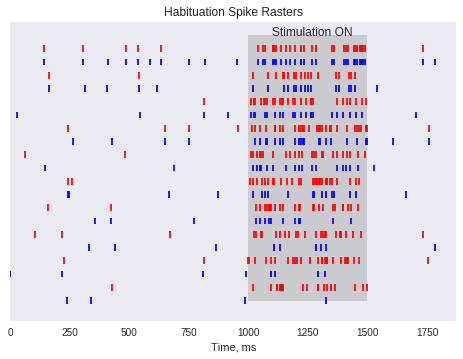

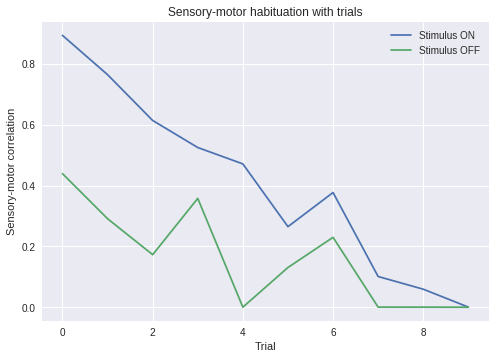

Neurons S and M activations are independent (motor_random=True)


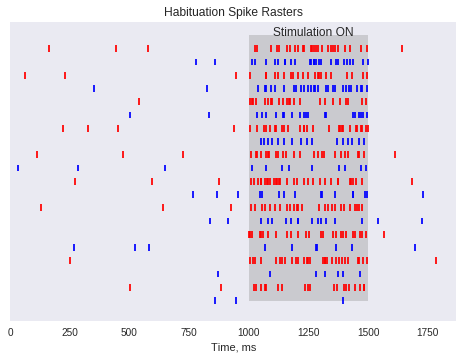

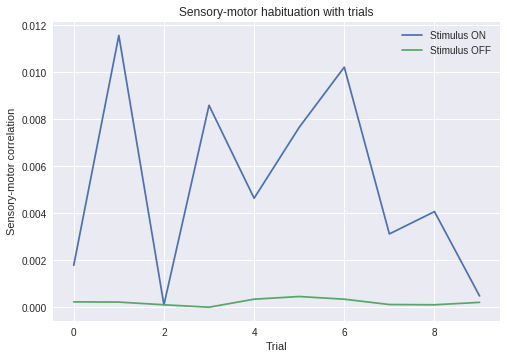

In [0]:
# One way to answer this question is by analyzing what information the motor
# neuron M stores about the sensory neuron S. Low information indicates that
# their activations are nearly independent.

def discrete_entropy(digits) -> float:
    """
    :param digits: realizations of a discrete random variable X
    :return estimated entropy of X in bits
    """
    unique, counts = np.unique(digits, return_counts=True)
    proba = counts / len(digits)
    entropy = sum(proba * np.log2(1 / proba))
    return entropy


def discrete_mutual_information(x, y) -> float:
    """
    :param x: realizations of a discrete random variable X
    :param y: realizations of a discrete random variable Y
    :return: estimated mutual information between X and Y in bits
    """
    entropy_x = discrete_entropy(x)
    entropy_x_given_y = 0
    for y_unique in np.unique(y):
        mask = y == y_unique
        x_given_y = x[mask]
        entropy_x_given_y += discrete_entropy(x_given_y) * np.mean(mask)
    info = entropy_x - entropy_x_given_y
    return info


def correlation(sensory_spikes, motor_spikes) -> float:
    """
    :param sensory_spikes: sensory spikes raster of one trial
    :param motor_spikes: motor spikes raster of one trial
    :return: (nonlinear) correlation between sensory and motor spikes
    """
    return 0


def test_habituation(motor_random=False, n_trials=10):
    dependent = "independent" if motor_random else "dependent"
    print(f"Neurons S and M activations are {dependent} (motor_random={motor_random})")
    sensory_motor_weights = np.linspace(1, 0, n_trials)
    sensory_spikes, motor_spikes = generate_experiments(sensory_motor_weights, motor_random=motor_random)
    visualize_spikes(sensory_spikes, motor_spikes)

    mask_stimulation = np.zeros(sensory_spikes.shape[1], dtype=bool)
    mask_stimulation[STIMULI_START: STIMULI_START + STIMULI_DURATION] = True

    correlation_stimulus_on = [correlation(s[mask_stimulation], m[mask_stimulation])
                               for s, m in zip(sensory_spikes, motor_spikes)]
    correlation_stimulus_off = [correlation(s[~mask_stimulation], m[~mask_stimulation])
                                for s, m in zip(sensory_spikes, motor_spikes)]

    plt.plot(range(n_trials), correlation_stimulus_on, label='Stimulus ON')
    plt.plot(range(n_trials), correlation_stimulus_off, label='Stimulus OFF')
    plt.legend()
    plt.xlabel('Trial')
    plt.ylabel('Sensory-motor correlation')
    plt.title('Sensory-motor habituation with trials')
    plt.show()

test_habituation(motor_random=False)
test_habituation(motor_random=True)

The correlation between sensory and motor spikes decreases with trial, as one can deduce from the raster plot. Yet the firing rate, averaged when the stimulus is ON versus OFF, is not enough to decide whether activations of neurons S and M are dependent or not - this is shown in the second example (`motor_random=True`), where motor neuron M was activated by unseen sensory neuron (not the given one).

### Time dependent spikes with memory

In the experiment above we assumed that the neuron responses are completetly described by its firing rate and each trial is independent of the previous ones (has no memory). If it isn't the case, you should account inter-spikes intervals of the previous activations. Here are a few instruments:

* Transfer entropy measures the information about the future state of a variable ($Y_{future}$) provided by another variable in the past ($X_{past}$) given the information provided by the past state of the variable ($Y_{past}$). Once these temporal relationships are defined, transfer entropy can be interpreted as a better measure of causal influence from $X$ to $Y$ than merely the mutual information between $X_{past}$ and $Y_{future}$, because transfer entropy measures the changes caused in $Y$ from $X$ that are not accounted for by the history of $Y$ alone \[N. Timme, 2018]. Well suited for time-shifted responses.

$$TE(X \to Y) = I(Y_{future};X_{past}|Y_{past}) = H(Y_{future}|Y_{past}) - H(Y_{future}|X_{past},Y_{past})$$

* [Perform analysis in the frequency domain](https://www.researchgate.net/publication/12774896_Information_theory_and_neural_coding). This approach is especially useful since, firstly, in most cases, neuron's firing frequency does not depend on the other frequencies of the same neuron and, secondly, you don't need to discretize time. You can compute how many information is transmitted at each frequency and sum up the results. In the example below two neurons have the same firing rate (9 spikes). If you assume their responses are completely described by their average firing rate, you'll get same information $I(Response; Stimuli)$ for both neurons. But, clearly, the first neuron activations are grouped in batches and have two firing frequency while the second neuron has only one firing frequency. This behaviour might explain the discrepancy of their responses on other stimuli.

```
Neuron 1 spikes: |||    |||    |||
Neuron 2 spikes: | | | | | | | | |
```


* Binirize the rasters data in the smallest time resolution such that each bin has at most one spike count. Then count how many same subsequences of length $L$ are found in the full sequence of length $N > L$. You can compute entropy of the repeated _sequences_, not the firing rates. For example, in a sequence of 12 spikes $[[0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 1, 0]]$ the first two subsequences are repeated. This might be a pattern.

### Take-home message

Information theory does not care about the data type and where it comes from. Mutual information measures _how much_ two random variables are dependent but it does not tell you _why_ they are dependent. If you substitute neuron spikes for taxi arrivals, you'll get same entropy and mutual information. Once you define marginal $p(y)$ and conditional $p(y|x)$ distributions, you just plug-in formulas for entropy and mutual information and you get the answer.